**Online Retailer Data Analysis - Part 7 - Market Response Models**

This notebook is the sixth of nine parts in a project designed to demonstrate various data analytics and data science techniques, highlighting how they can enhance business intelligence and drive effective decision-making.

Using an example dataset from a Store Item Demand Forecasting Challenge, this project will cover the following topics:

1. Calculating Metrics
2. Customer Segmentation
3. Customer Lifetime Value Prediction
4. Churn Prediction
5. Predicting Next Purchase Day
6. Predicting Sales
7. **Market Response Models**
8. Uplift Modeling
9. A/B Testing Design and Execution

By using the models we have built in the previous articles, we can easily segment the customers and predict their lifetime value (LTV) for targeting purposes. As a side note, we also know what will be our sales numbers. But how we can increase our sales? If we do a discount today, how many incremental transactions should we expect?

Segmenting customers and doing A/B tests enable us to try lots of different ideas for generating incremental sales. This is one of the building blocks of Growth Hacking. You need to ideate and experiment continuously to find growth opportunities.

Splitting the customers who we are going to send the offer into test and control groups helps us to calculate incremental gains.

An example can be:

From a Target Group:

1. Test Group A gets a 18% Discount
2. Test Group B gets a 17% Discount
3. Control Group Doesn't get an additional offer, so 15% discount

We'd like to know:
1. Does giving an offer increase conversion?
2. If so, what offer performs the best? Discount or Buy one Get one?


In the real world, it is much more complicated. Some offers perform better on specific segments. So you need to create a portfolio of offers for selected segments. Moreover, you can’t count on conversion as the only criterion of success. There is always a cost trade-off. Generally, while conversion rates go up, cost increases too. That’s why sometimes you need to select an offer that is cost-friendly but brings less conversion.

If we predict the effect of giving an offer, we can easily maximize our transactions and have a forecast of the cost. Market Response Models help us building this framework. But there is more than one way of doing it. We can group them into two:

1- If you don’t have a control group (imagine you did an open promotion to everyone and announced it on social media), then you cannot calculate the incrementality. For this kind of situation, better to build a regression model that predicts overall sales. *The prior assumption will be that the model will provide higher sales numbers for the promo days.*

To build this kind of model, your dataset should include promo & non-promo days sales numbers so that the machine learning model can calculate the incrementality.

2- If you have a control group, *you can build the response model based on segment or individual level.*

For both of them, the assumption is the same. Giving an offer should increase the probability of conversion. The uptick in the individuals’ conversion probability will bring us the incremental conversion.

In [34]:

from datetime import datetime, timedelta,date
import pandas as pd
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from __future__ import division #must if you use python 2
from sklearn.cluster import KMeans


import sklearn
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split


#function for ordering cluster numbers for given criteria
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [37]:
from google.colab import files
uploaded = files.upload()

import io
df = pd.read_csv(io.BytesIO(uploaded['datacopy.csv']))



Saving datacopy.csv to datacopy.csv


In [38]:
df.head(10)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0
5,6,134.83,0,1,Surburban,0,Phone,Buy One Get One,1
6,9,280.20,1,0,Surburban,1,Phone,Buy One Get One,0
7,9,46.42,0,1,Urban,0,Phone,Buy One Get One,0
8,9,675.07,1,1,Rural,1,Phone,Discount,0
9,10,32.84,0,1,Urban,1,Web,Buy One Get One,0


Our first 8 columns are providing individual-level data and conversion column is our label to predict:

- recency: months since last purchase
- history: $value of the historical purchases
- used_discount/used_bogo: indicates if the customer used a discount or buy one - get one before
zip_code: class of the zip code as Suburban/Urban/Rural
-is_referral: indicates if the customer was acquired from referral channel
- channel: channels that the customer using, Phone/Web/Multichannel
- offer: the offers sent to the customers, Discount/But One Get One/No Offer

We will be building a binary classification model for scoring the conversion probability of all customers. For doing that, we are going to follow the steps below:

- Building the uplift formula
- Exploratory Data Analysis (EDA) & Feature Engineering
- Scoring the conversion probabilities
- Observing the results on the test set

**Uplift Formula**

Conversion Uplift: Conversion rate of test group - conversion rate of control group

Order Uplift: Conversion uplift * # converted customer in test group

Revenue Uplift: Order Uplift * Average order $ value *italicised text*

In [39]:
def calc_uplift(df):
    #assigning 25$ to the average order value
    avg_order_value = 25

    #calculate conversions for each offer type
    base_conv = df[df.offer == 'No Offer']['conversion'].mean()
    disc_conv = df[df.offer == 'Discount']['conversion'].mean()
    bogo_conv = df[df.offer == 'Buy One Get One']['conversion'].mean()

    #calculate conversion uplift for discount and bogo
    disc_conv_uplift = disc_conv - base_conv
    bogo_conv_uplift = bogo_conv - base_conv

    #calculate order uplift
    disc_order_uplift = disc_conv_uplift * len(df[df.offer == 'Discount']['conversion'])
    bogo_order_uplift = bogo_conv_uplift * len(df[df.offer == 'Buy One Get One']['conversion'])

    #calculate revenue uplift
    disc_rev_uplift = disc_order_uplift * avg_order_value
    bogo_rev_uplift = bogo_order_uplift * avg_order_value


    print('Discount Conversion Uplift: {0}%'.format(np.round(disc_conv_uplift*100,2)))
    print('Discount Order Uplift: {0}'.format(np.round(disc_order_uplift,2)))
    print('Discount Revenue Uplift: ${0}\n'.format(np.round(disc_rev_uplift,2)))

    print('-------------- \n')
    print('BOGO Conversion Uplift: {0}%'.format(np.round(bogo_conv_uplift*100,2)))
    print('BOGO Order Uplift: {0}'.format(np.round(bogo_order_uplift,2)))
    print('BOGO Revenue Uplift: ${0}'.format(np.round(bogo_rev_uplift,2)))

In [40]:
calc_uplift(df)

Discount Conversion Uplift: 7.66%
Discount Order Uplift: 1631.89
Discount Revenue Uplift: $40797.35

-------------- 

BOGO Conversion Uplift: 4.52%
BOGO Order Uplift: 967.4
BOGO Revenue Uplift: $24185.01


Discount looks like a better option if we want to get more conversion. It brings 7.6% uptick compared to the customers who didn’t receive any offer. BOGO (Buy One Get One) has 4.5% uptick as well.

Let’s start exploring which factors are the drivers of this incremental change.

**EDA & Feature Engineering**

Let's check every feature for their impact on conversion



**1. Recency **

We would assume the conversion should go down while recency goes up since inactive customers are less likely to buy again:

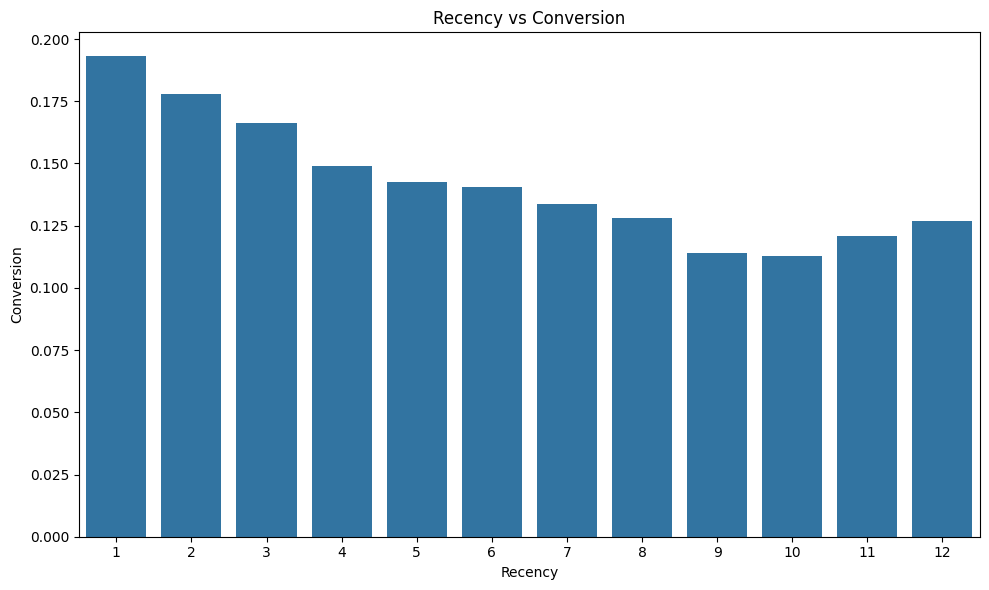

In [41]:
df_plot = df.groupby('recency').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='recency', y='conversion')

# Customizing the plot
plt.title('Recency vs Conversion')
plt.xlabel('Recency')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

**2. History**

We will create a history cluster and observe its impact. Let’s apply k-means clustering to define the significant groups in history:

In [42]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(df[['history']])
df['history_cluster'] = kmeans.predict(df[['history']])

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Like we did in previous notebooks, we will order the cluster numbers using the function we defined:

In [43]:
df_data = order_cluster('history_cluster', 'history', df, True)

#print how the clusters will look like
df_data.groupby('history_cluster').agg({'history': ['mean', 'min', 'max'],
                                   'conversion':['count', 'mean']})

history                   conversion          
                        mean      min      max      count      mean
history_cluster                                                    
0                  74.417464    29.99   161.79      32468  0.122613
1                 248.736043   161.80   366.47      17978  0.160585
2                 482.761135   366.53   652.02       8997  0.180393
3                 818.142015   652.07  1122.08       3673  0.194392
4                1422.038009  1122.34  3345.93        884  0.213801

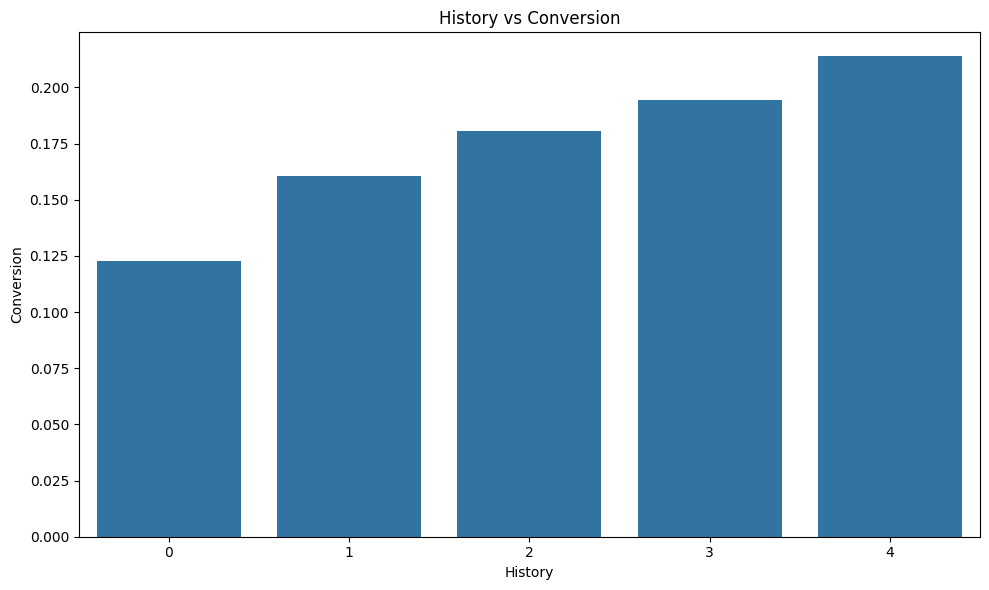

In [44]:
#Now let's plot conversion by each cluster

df_plot = df_data.groupby('history_cluster').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='history_cluster', y='conversion')

# Customizing the plot
plt.title('History vs Conversion')
plt.xlabel('History')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

Customers with higher $ value of history are more likely to convert.

3. **Used Discount & BOGO**

In [45]:
df_data.groupby(['used_discount', 'used_bogo', 'offer']).agg({'conversion': 'mean'})

conversion
used_discount used_bogo offer                      
0             1         Buy One Get One    0.169794
                        Discount           0.166388
                        No Offer           0.095808
1             0         Buy One Get One    0.110892
                        Discount           0.168968
                        No Offer           0.099813
              1         Buy One Get One    0.251653
                        Discount           0.314993
                        No Offer           0.180549

It may be confusing to interpret first, but in row 8 is where the customer used a discount and used BOGO, and the conversion rate was the highest, 0.31 or 31.5%

4. **Zip Code**

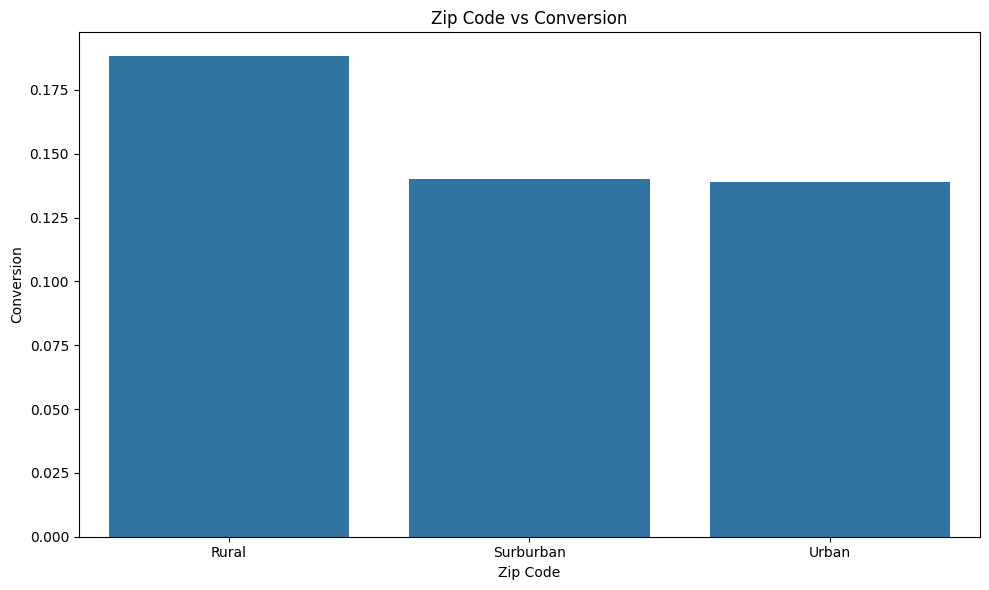

In [46]:
df_plot = df_data.groupby('zip_code').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='zip_code', y='conversion')

# Customizing the plot
plt.title('Zip Code vs Conversion')
plt.xlabel('Zip Code')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

5. **Referral**

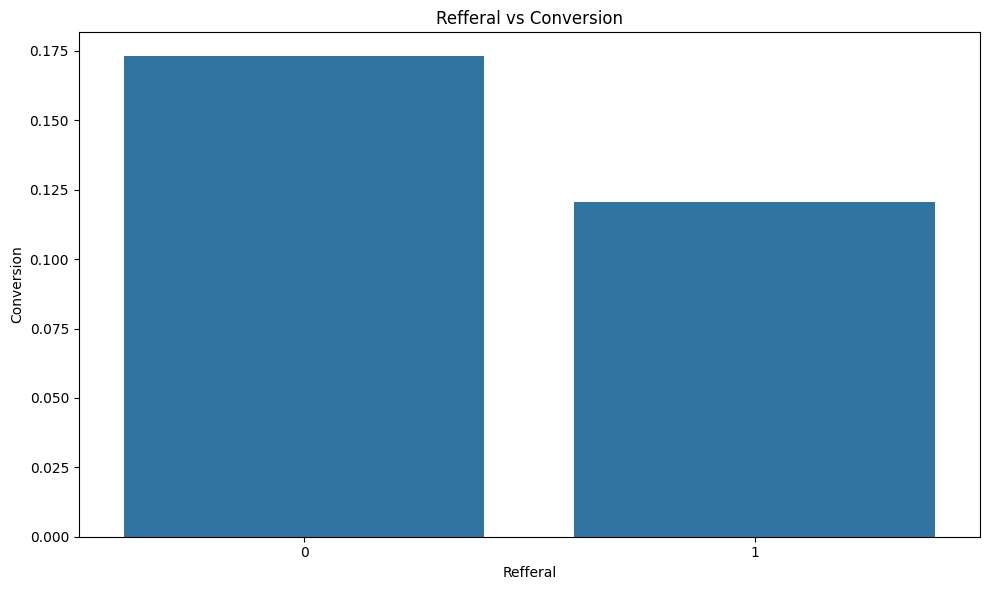

In [47]:
df_plot = df_data.groupby('is_referral').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='is_referral', y='conversion')

# Customizing the plot
plt.title('Refferal vs Conversion')
plt.xlabel('Refferal')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

Interestingly, customers from referral channel have about 5% less conversion

6. **Channel**

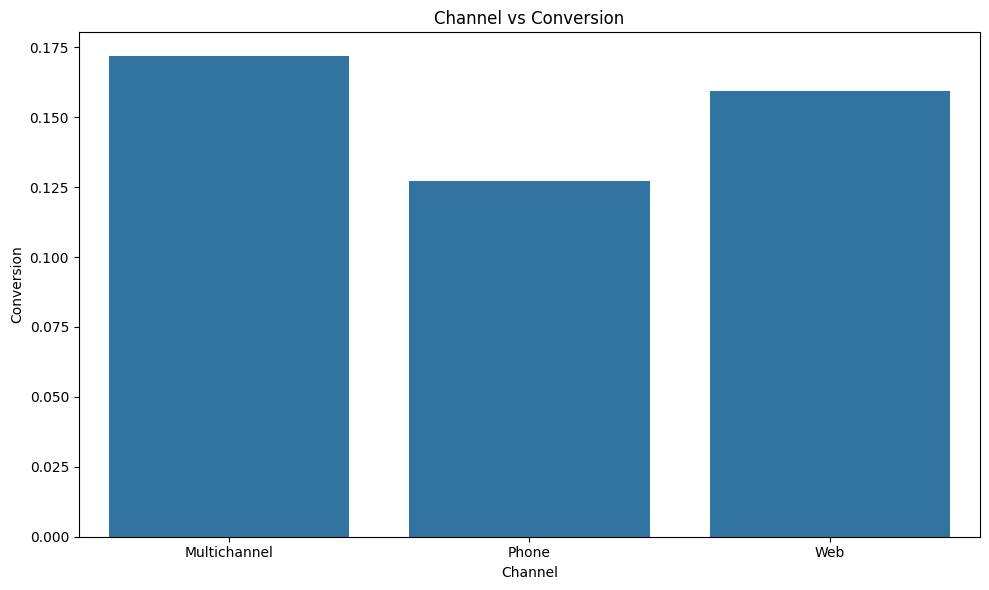

In [48]:
df_plot = df_data.groupby('channel').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='channel', y='conversion')

# Customizing the plot
plt.title('Channel vs Conversion')
plt.xlabel('Channel')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

7. **Offer Type**

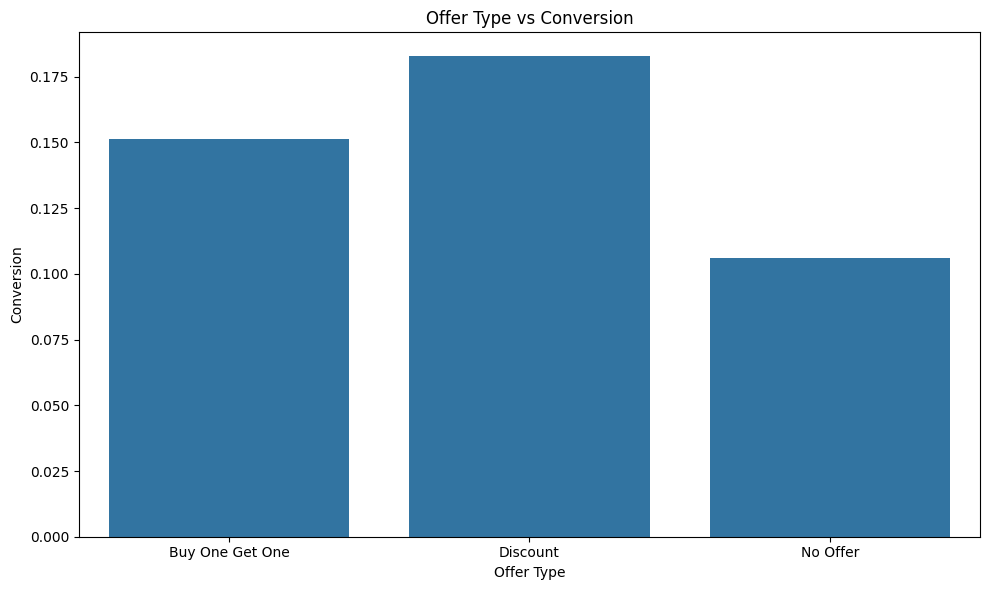

In [49]:
df_plot = df_data.groupby('offer').conversion.mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_plot, x='offer', y='conversion')

# Customizing the plot
plt.title('Offer Type vs Conversion')
plt.xlabel('Offer Type')
plt.ylabel('Conversion')
plt.tight_layout()  # Adjust layout to fit labels

# Display the plot
plt.show()

Customers who get discount offers show ~18% conversion whereas it is ~15% for BOGO. If customers don’t get an offer, their conversion rate drops by ~4%.

Feature Engineering of this data will be pretty simple. We will apply .get_dummies() to convert categorical columns to numerical ones:

In [50]:
df_model = df_data.copy()
df_model = pd.get_dummies(df_model)

It is time to build our machine learning model to score conversion probabilities.

**Scoring conversion probabilities**

To build our model, we need to follow the steps we mentioned earlier in the articles.

Let’s start with splitting features and the label:

In [51]:
df_model.head()

,recency,history,used_discount,used_bogo,is_referral,conversion,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer
0,10,142.44,1,0,0,0,0,False,True,False,False,True,False,True,False,False
1,2,45.34,1,0,0,0,0,False,False,True,False,False,True,True,False,False
2,6,134.83,0,1,0,1,0,False,True,False,False,True,False,True,False,False
3,9,46.42,0,1,0,0,0,False,False,True,False,True,False,True,False,False
4,10,32.84,0,1,1,0,0,False,False,True,False,False,True,True,False,False


In [52]:
df_model.conversion.mean()

0.14678125

It is time to build our machine learning model to score conversion probabilities.

**Scoring conversion probabilities**
To build our model, we need to follow the steps we mentioned earlier in the articles.

Let’s start with splitting features and the label:

Finally, we need to understand if our model works well or not.

**Results on test set**


Now we assume, the difference in the probability of discount, bogo and control group should be similar to conversion differences between them.

We need to use our test set to find it out.

In [53]:
#create feature set and labels
X = df_model.drop(['conversion'],axis=1)
y = df_model.conversion

In [54]:
X.columns

Index(['recency', 'history', 'used_discount', 'used_bogo', 'is_referral',
       'history_cluster', 'zip_code_Rural', 'zip_code_Surburban',
       'zip_code_Urban', 'channel_Multichannel', 'channel_Phone',
       'channel_Web', 'offer_Buy One Get One', 'offer_Discount',
       'offer_No Offer'],
      dtype='object')

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=56)

In [56]:
xgb_model = xgb.XGBClassifier().fit(X_train, y_train)

In [57]:
X_test['proba'] = xgb_model.predict_proba(X_test)[:,1]

In [58]:
X_test.head(5)

,recency,history,used_discount,used_bogo,is_referral,history_cluster,zip_code_Rural,zip_code_Surburban,zip_code_Urban,channel_Multichannel,channel_Phone,channel_Web,offer_Buy One Get One,offer_Discount,offer_No Offer,proba
32277,4,55.19,0,1,1,0,False,True,False,False,True,False,False,True,False,0.096645
12824,1,29.99,1,0,1,0,False,False,True,False,True,False,False,False,True,0.049096
20159,11,111.73,1,0,0,0,True,False,False,False,False,True,False,True,False,0.183196
41575,6,239.62,1,0,0,1,False,False,True,False,False,True,False,True,False,0.119724
10736,10,29.99,1,0,0,0,False,True,False,False,False,True,False,False,True,0.078769


In [59]:
#Check the x test proba mean
X_test.proba.mean()

0.14734566

In [62]:
#Check the y test mean to see who close
y_test.mean()

0.14390625

We need to add the conversion column back into X_test:

In [63]:
X_test['conversion'] = y_test

In [65]:
#Check BOGO Conversion mean
X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean()

0.14579958342976163

In [66]:
# Let's see how proabilities did
X_test[X_test['offer_Buy One Get One'] == 1].proba.mean()


0.1528802

In [67]:
X_test[X_test['offer_Discount'] == 1].conversion.mean()

0.18548009367681498

In [68]:
X_test[X_test['offer_Discount'] == 1].proba.mean()

0.18055345

In [69]:

X_test[X_test['offer_No Offer'] == 1].conversion.mean()

0.09978617248752673

In [70]:
X_test[X_test['offer_No Offer'] == 1].proba.mean()

0.10797476

Now we assume, the difference in the probability of discount, bogo and control group should be similar to conversion differences between them.

We need to use our test set to find it out.

Let’s calculate predicted and real order upticks for discount:

In [71]:
real_disc_uptick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean())
pred_disc_uptick = len(X_test)*(X_test[X_test['offer_Discount'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [72]:
print('Real Discount Uptick - Order: {}, Revenue: {}'.format(real_disc_uptick, real_disc_uptick*25))
print('Predicted Discount Uptick - Order: {}, Revenue: {}'.format(pred_disc_uptick, pred_disc_uptick*25))

Real Discount Uptick - Order: 1096.8821912228896, Revenue: 27422.054780572238
Predicted Discount Uptick - Order: 929.0072441101074, Revenue: 23225.181102752686


The results are pretty good. The real order uptick was 966 and the model predicted it as 948 (1.8% error).

Revenue uptick prediction comparison: 24150 vs 23700.

We need to check if the results are good for BOGO as well:

In [73]:
real_bogo_uptick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].conversion.mean() - X_test[X_test['offer_No Offer'] == 1].conversion.mean())
pred_bogo_uptick = len(X_test)*(X_test[X_test['offer_Buy One Get One'] == 1].proba.mean() - X_test[X_test['offer_No Offer'] == 1].proba.mean())

In [74]:
print('Real Discount Uptick - Order: {}, Revenue: {}'.format(real_bogo_uptick, real_bogo_uptick*25))
print('Predicted Discount Uptick - Order: {}, Revenue: {}'.format(pred_bogo_uptick, pred_bogo_uptick*25))

Real Discount Uptick - Order: 588.9716600606066, Revenue: 14724.291501515165
Predicted Discount Uptick - Order: 574.7897148132324, Revenue: 14369.74287033081


Promising results for BOGO:

Order uptick - real vs predicted: 563 vs 595

Revenue uptick — real vs predicted: 14075 vs 14875

The error rate is around 5.6%. The model can benefit from improving the prediction scores on BOGO offer type.

Calculating conversion probabilities help us a lot in different areas as well. We have predicted the return of the different types of offers but it can help us to find out who to target for maximizing the uplift as well. In the next notebook, we will build our own uplift model.